In [1]:
%pip install torchbnn
%pip install pytorch-lightning
%pip install tensorboard

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pytorch_lightning as nnl # polars is pl
import matplotlib.pyplot as plt
import torchbnn as bnn
import torch.nn as nn
import seaborn as sns
import pandas as pd
import numpy as np

import itertools
import warnings
import torch

from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from torch.utils.data import DataLoader, TensorDataset, Dataset, random_split
from copy import deepcopy
from IPython.display import Markdown

from wave_generator import WaveGen

In [3]:
a = torch.tensor([[1,2],[4,1],[5,6]])
display(a)
display(torch.argsort(a, dim=1))

tensor([[1, 2],
        [4, 1],
        [5, 6]])

tensor([[0, 1],
        [1, 0],
        [0, 1]])

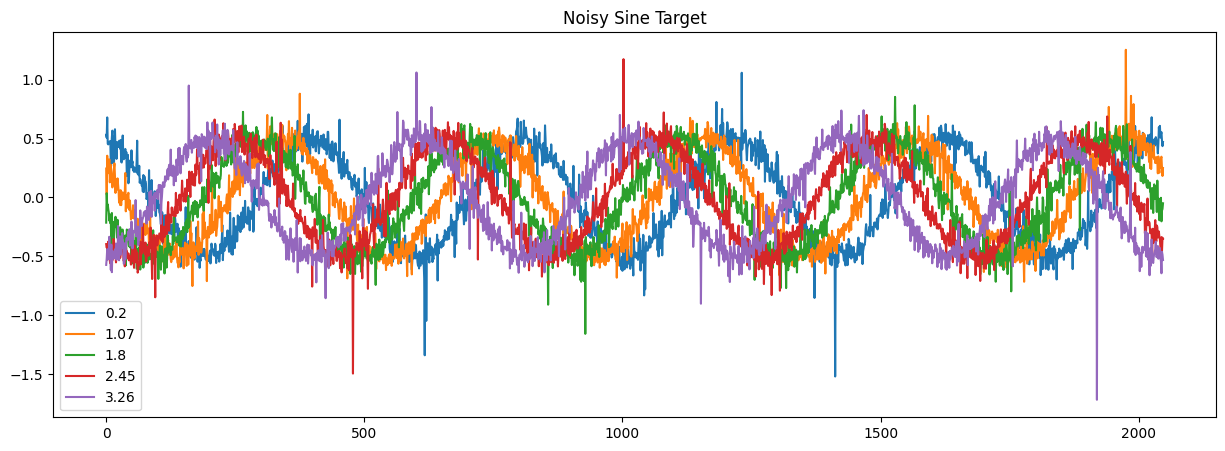

In [4]:
plt.figure(figsize=(15,5))
for phase in [0.2, 1.07, 1.8, 2.45, 3.26]:
    large_wave = WaveGen(size=2048).linear_phase(phase).cos().amp(.5).t_noise(std=.05, dof=3).sample(1).samples.squeeze(axis=0)
    plt.plot(large_wave, label=str(phase))
plt.title('Noisy Sine Target')
plt.legend()
plt.show()

In [5]:
def create_ordinal_waves(phases, size=2048):
    waves = list()
    for phase in phases:
        wave = WaveGen(size=size).linear_phase(phase).cos().amp(.5).t_noise(std=.05, dof=3).sample(1).samples.squeeze(axis=0)
        wave = np.diff(wave)
        waves.append(wave)
    continuous_wave = torch.from_numpy(np.stack(waves, axis=1)).float()
    ordinal_wave = torch.argsort(continuous_wave, dim=1).float() / (continuous_wave.shape[1] - 1)
    assert continuous_wave.shape == ordinal_wave.shape
    return continuous_wave, ordinal_wave

size = 4096
phases = [0.2, 1.07, 1.8, 2.45, 3.26]
continuous_wave, ordinal_wave = create_ordinal_waves(phases, size=size)
display(ordinal_wave.shape)

torch.Size([4095, 5])

In [6]:
class ForwardRankDataset(Dataset):
    def __init__(self, continuous_wave, ordinal_wave, train_length=1, test_length=1, gap=100):
        assert continuous_wave.shape == ordinal_wave.shape, f'Size mismatch, {continuous_wave.shape} != {ordinal_wave.shape}'
        if not ordinal_wave.dim() == 2:
            raise ValueError('Expected 2 dimensional tensor with last dimension shape > 1')
            
        self._length = continuous_wave.shape[0]
        self._output_size = ordinal_wave.shape[1]
        self._cont = continuous_wave
        self._rank = ordinal_wave
            
        self.train_length = train_length
        self.test_length = test_length
        self.gap = gap
        return
    
    @property
    def shape(self):
        return self._length - 1 - self.test_length - self.gap - self.train_length, self._output_size - 1

    def __len__(self):
        return self.shape[0]

    def __getitem__(self, start_idx):
        if isinstance(start_idx, slice):
            raise NotImplementedError('Only integers, not slices, are acceptable')
            
        if self.train_length > 1 or self.test_length > 1:
            in_indices = torch.linspace(
                start_idx, 
                start_idx + self.train_length, 
                self.train_length, 
                dtype=torch.int
            )
            forward_indices = torch.linspace(
                start_idx + self.train_length + self.gap, 
                start_idx + self.train_length + self.gap + self.test_length,
                self.test_length, 
                dtype=torch.int
            )
        else:
            in_indices = start_idx
            forward_indices = start_idx + self.gap + 1
            
        back_data = self._cont[in_indices,:]
        forw_data = self._rank[forward_indices,:]
#         assert back_data.shape == (self.train_length, self._output_size), back_data.shape
#         assert forw_data.shape == (self.test_length, self._output_size), forw_data.shape
        
        return back_data, forw_data

In [7]:
class HorizontalRanker(nnl.LightningModule):
    def __init__(
        self,
        n_input_features,
        n_output_features,
        n_hidden_features=16,
        loss_id='tau',
    ):
        super(HorizontalRanker, self).__init__()
        self.input = nn.Linear(n_input_features, n_hidden_features)
        self.activation = nn.ReLU(inplace=True)
        self.hidden = nn.Linear(n_hidden_features, n_hidden_features // 2)
        self.output = nn.Linear(n_hidden_features // 2, n_output_features)
        
        if loss_id == 'tau':
            self.c = tm.KendallRankCorrCoef()
        elif loss_id == 'spearman':
            self.c = tm.SpearmanCorrCoef()
        elif loss_id == 'mae':
            self.c = tm.MeanAbsoluteError()
        elif loss_id == 'contingency':
            self.c = tm.PearsonsContingencyCoefficient(n_output_features)
        elif loss_id == 'ranking_precision':
            self.c = tm.MultilabelRankingAveragePrecision(n_output_features)
        elif loss_id == 'ranking_loss':
            self.c = tm.MultilabelRankingLoss(n_output_features)
        return
    
    def forward(self, x):
        x = self.input(x)
        x = self.activation(x)
        x = self.hidden(x)
        x = self.activation(x)
        x = self.output(x)
#         x = torch.softmax(x)
        return x

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer
    
    def training_step(self, train_batch, batch_idx, min_weight=.05):
        x, y = train_batch
        y_hat = self.forward(x)

        loss = self.c(y_hat, y) # + penalty_term
        self.log('train_loss', loss)
        return loss

    def validation_step(self, val_batch, batch_idx, min_weight=.05):
        x, y = val_batch
        y_hat = self.forward(x)
        
        loss = self.c(y_hat, y)  # + penalty_term
        self.log('val_loss', loss)
        return loss

In [8]:
import math
import torchmetrics as tm

class BinaryRankAggregator(nn.Module):
    def __init__(
        self,
        n_input_features,
        n_output_features,
#         n_hidden_features=16,
        loss='tau',
        all_weight=.5,
        comb_weight=.5,
    ):
        self.n_input_features = n_input_features
        self.n_output_features = n_output_features
        self.n_hidden_features = n_hidden_features
        self.all_weight = all_weight
        self.comb_weight = comb_weight
        
        self.n_subnets = math.comb(n_output_features, 2)
        assert self.n_subnets < 64, 'That`s a lot of subnets'
        self.unique_indices = list(range(self.n_subnets))
        self.subnet_indices = list(itertools.combinations(self.unique_indices, 2))
        self.index_dict = dict.from_keys(self.unique_indices, list())
#         self.net_dict = dict()
        
        # Binary Partially Connected Layer
#         self.binput_layer = nn.Linear(self.n_input_features, self.n_subnets)
        self.full_subnets = list()    
        for i, (ind1, ind2) in enumerate(range(self.subnet_indices)):
            assert ind1 in self.index_dict
            assert ind2 in self.index_dict
            
            self.full_subnets.append(
                nn.Linear(n_input_features, 1)
            )
            self.index_dict[ind1].append(i)
            self.index_dict[ind2].append(i)
            # this shouldn't be strictly necessary
#             self.net_dict[(ind1, ind2)] = i
            
        for i, nodes in self.index_dict.items():
            assert len(nodes) == self.n_subnets - 1, f'{len(nodes)} != {self.n_output_features - 1}'
            
        self.partial_subnets = list()
        for i in self.unique_indices:
            self.partial_subnets.append(
                nn.Linear(self.n_output_features - 1, 1)
            )
            
#         self.bagg_layer = nn.Linear(self.n_subnets, n_output_features)
        #########################
        
        # Regular Feedforward Net
        self.hinput_layer = nn.Linear(n_input_features, n_hidden_features)
        self.hagg_layer = nn.Linear(n_hidden_features, n_output_features)
        #########################
        
        self.output_layer = nn.Linear(n_output_features, n_output_features)
        
        self.tau_loss = tm.KendallRankCorrCoef()
        self.bin_loss = nn.BCELoss()
        return

    def partial_forward(self, x):
        initial_features = [full_subnet(x) for full_subnet in self.full_subnets]
        binary_x = torch.cat(initial_features, dim=0)
        
        partial_features = list()
        for i, partial_subnet in enumerate(self.partial_subnets):
            partial_feature = torch.cat([initial_features[j] for j in self.index_dict[i]], dim=0)
            partial_features.append(partial_subnet(partial_feature))
            
        feature_x = torch.cat(partial_features, dim=0)
        return feature_x, binary_x
    
    def full_forward(self, x):
        x = self.hinput_layer(x)
        x = self.hagg_layer(x)
        return x
    
    def forward(self, x):
        x1 = self.full_forward(x)
        x2, binary_x = self.partial_forward(x)
        x = x1 + x2
        x = self.output_layer(x)
        return x, binary_x
    
    def loss(self, all_pred, comb_pred, all_truth, comb_truth):
        tau_loss = -self.tau_loss(all_pred, all_truth)
        bin_loss = self.bin_loss(comb_pred, comb_truth)
        loss = self.tau_loss * self.all_weight + self.bin_loss * self.comb_weight
        return loss

[K Fold Ensembling](https://www.sciencedirect.com/science/article/abs/pii/S0304407622000975)

In [9]:
batch_size = 32
train_size = int(size * .8)
test_size = size - train_size - 1

assert continuous_wave.shape == ordinal_wave.shape
continuous_train = continuous_wave[:train_size,:]
ordinal_train = ordinal_wave[:train_size,:]
assert continuous_wave.shape == ordinal_wave.shape

continuous_val = continuous_wave[train_size:,:]
ordinal_val = ordinal_wave[train_size:,:]
assert continuous_wave.shape == ordinal_wave.shape

train_dataset = ForwardRankDataset(continuous_train, ordinal_train)
val_dataset = ForwardRankDataset(continuous_val, ordinal_val)
train_loader = DataLoader(train_dataset, batch_size=batch_size)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

print(train_dataset._output_size)
model = HorizontalRanker(
    train_dataset._output_size,
    train_dataset._output_size,
    n_hidden_features=16,
    loss_id='mae',
).float()

trainer = nnl.Trainer(precision='bf16-mixed', max_epochs=100, callbacks=[EarlyStopping(monitor='val_loss', min_delta=0., patience=5)])
trainer.fit(model, train_loader, val_loader)

5


Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type              | Params
-------------------------------------------------
0 | input      | Linear            | 96    
1 | activation | ReLU              | 0     
2 | hidden     | Linear            | 136   
3 | output     | Linear            | 45    
4 | c          | MeanAbsoluteError | 0     
-------------------------------------------------
277       Trainable params
0         Non-trainable params
277       Total params
0.001     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

C:\Users\Nick\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\Nick\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
display(Markdown('[Tensorboard](http://localhost:6006/#timeseries)'))
!tensorboard --logdir .

[Tensorboard](http://localhost:6006/#timeseries)